<a href="https://colab.research.google.com/github/IPL-UV/rbig_jax/blob/master/notebooks/rbig_jax_scan_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jax PlayGround

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [1]:
#@title Install Packages
%%capture
!pip install "git+https://github.com/google/jax.git#egg=jax" --force
!pip install --upgrade jaxlib --force

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as np
import jax.random as random

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

In [3]:
#@title Data
def get_data(
    N: int = 30,
    input_noise: float = 0.15,
    output_noise: float = 0.15,
    N_test: int = 400,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, None]:
    onp.random.seed(0)
    X = np.linspace(-1, 1, N)
    Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y += output_noise * onp.random.randn(N)
    Y -= np.mean(Y)
    Y /= np.std(Y)

    X += input_noise * onp.random.randn(N)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = np.linspace(-1.2, 1.2, N_test)

    return X[:, None], Y[:, None], X_test[:, None]


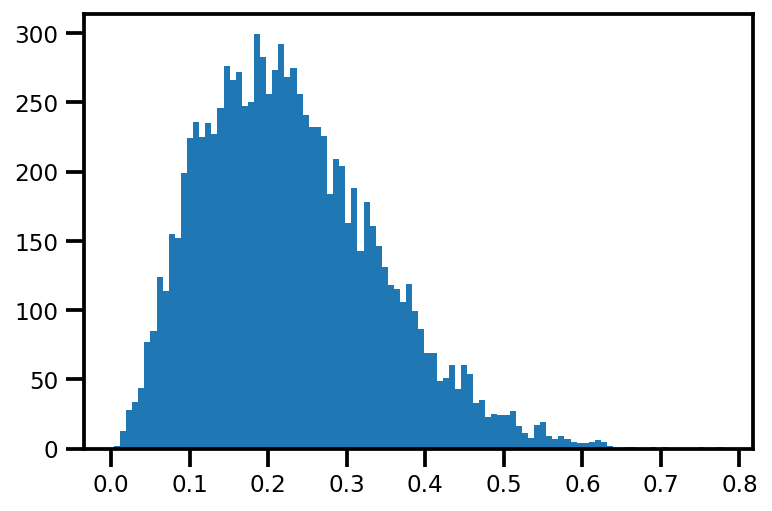

In [4]:
#@title Distribution Data
from scipy.stats import beta

n_samples = 10_000

a, b = 3.0, 10.0
data_dist = beta(a, b)


x_samples = data_dist.rvs(n_samples, 123)

# x_samples = data_dist.rvs(1_000, 123)

plt.hist(x_samples, bins=100);

### Univariate Normalization

#### Histogram Transformation

In [5]:
from typing import Union, Tuple

def get_domain_extension(
    data: np.ndarray, extension: Union[float, int],
) -> Tuple[float, float]:
    """Gets the extension for the support
    
    Parameters
    ----------
    data : np.ndarray
        the input data to get max and minimum
    extension : Union[float, int]
        the extension
    
    Returns
    -------
    lb : float
        the new extended lower bound for the data
    ub : float
        the new extended upper bound for the data
    """

    # case of int, convert to float
    if isinstance(extension, int):
        extension = float(extension / 100)

    # get the domain
    domain = np.abs(np.max(data) - np.min(data))

    # extend the domain
    domain_ext = extension * domain

    # get the extended domain
    lb = np.min(data) - domain_ext
    up = np.max(data) + domain_ext

    return lb, up

def histogram_transform(
    X: np.ndarray,
    support_extension: Union[int, float] = 10,
    nbins: int=100,
    precision: int = 1_000,
    alpha: float = 1e-5,
):
    """Get parameters via the histogram transform
    
    Parameters
    ----------
    X : np.ndarray, (n_samples)
        input to get histogram transformation
    
    support_extension: Union[int, float], default=10
        extend the support by x on both sides
    
    precision: int, default=1_000
        the number of points to use for the interpolation
    
    alpha: float, default=1e-5
        the regularization for the histogram. ensures that
        there are no zeros in the empirical pdf.
    
    Returns
    -------
    X_trans : np.ndarray, (n_samples,)
        the data transformed via the empirical function
    log_dX : np.ndarray, (n_samples,)
        the log pdf of the data
    Params: namedTuple
        a named tuple with the elements needed for the
        forward and inverse transformation
    
    Examples
    --------
    >>> # single set of parameters
    >>> X_transform, params = get_params(x_samples, 10, 1000)
    
    >>> # example with multiple dimensions
    >>> multi_dims = jax.vmap(get_params, in_axes=(0, None, None))
    >>> X_transform, params = multi_dims(X, 10, 1000)
    """
    # get number of samples
    n_samples = np.shape(X)[0]

    # get number of bins (default square root heuristic)
    # nbins = np.sqrt(n_samples).astype(np.int32)
    # print(nbins)
    # print(type(nbins))

    # bin_edges = np.linspace(np.min(X), np.max(X), num=100)
    bin_edges = np.histogram_bin_edges(X, bins=nbins)

    bins = np.histogram(X, bins=bin_edges)


    # get histogram counts and bin edges
    counts, bin_edges = np.histogram(X, bins=bin_edges)

    # return X

    # add regularization
    counts = np.array(counts) + alpha

    # get bin centers and sizes
    bin_centers = np.mean(np.vstack((bin_edges[0:-1], bin_edges[1:])), axis=0)
    bin_size = bin_edges[2] - bin_edges[1]

    # =================================
    # CDF Estimation
    # =================================
    c_sum = np.cumsum(counts)
    cdf = (1 - 1 / n_samples) * c_sum / n_samples

    incr_bin = bin_size / 2

    # ===============================
    # Extend CDF Support
    # ===============================
    lb, ub = get_domain_extension(X, support_extension)

    # get new bin edges
    new_bin_edges = np.hstack((lb, np.min(X), bin_centers + incr_bin, ub,))

    extended_cdf = np.hstack((0.0, 1.0 / n_samples, cdf, 1.0))

    new_support = np.linspace(new_bin_edges[0], new_bin_edges[-1], int(precision))

    uniform_cdf = jax.lax.cummax(
        np.interp(new_support, new_bin_edges, extended_cdf), axis=0
    )

    # Normalize CDF estimation
    uniform_cdf /= np.max(uniform_cdf)

    return np.interp(X, new_support, uniform_cdf)

In [6]:
X_trans = histogram_transform(x_samples)

2021-02-02 07:00:14,425:WARNING:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


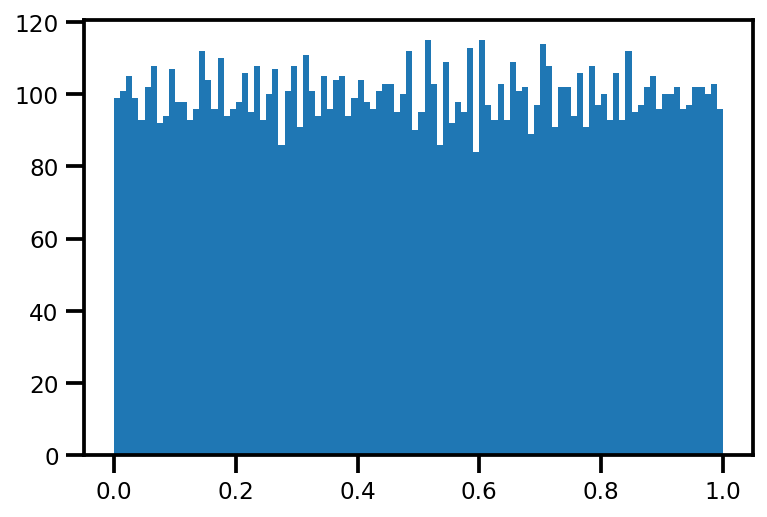

In [7]:
plt.figure()
plt.hist(X_trans, 100);
plt.show()

In [8]:
def householder_prod_body(carry, inputs):
  x = carry
  v = inputs
  return householder(x, v), 0


def f(carry, inputs):
    return histogram_transform(carry, nbins=100), 0

# f = histogram_transform
init = x_samples
xs = None


In [9]:
%%time

length = 1_000

state, results = jax.lax.scan(f=f, init=init, xs=xs, length=length)

CPU times: user 1.59 s, sys: 20.3 ms, total: 1.61 s
Wall time: 1.62 s


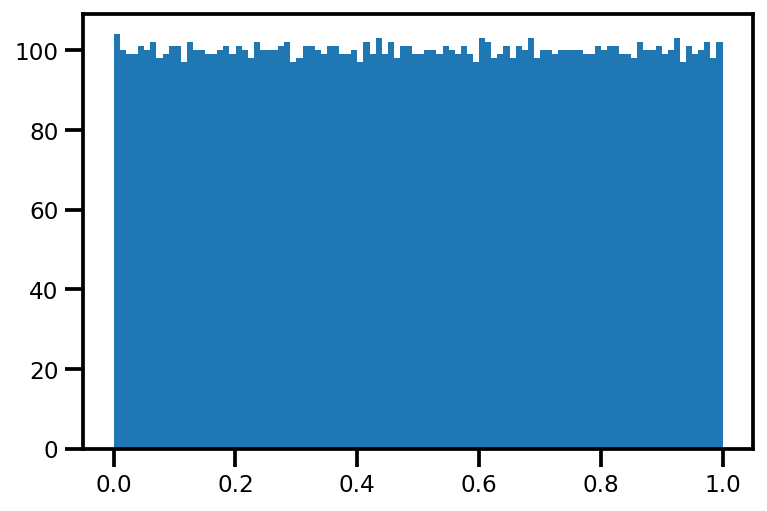

In [10]:
plt.figure()
plt.hist(state, 100);
plt.show()

## 2D Example

In [11]:
def get_classic(n_samples=10_000, seed=123):
    rng = onp.random.RandomState(seed=seed)
    x = onp.abs(2 * rng.randn(1, n_samples))
    y = onp.sin(x) + 0.25 * rng.randn(1, n_samples)
    return onp.vstack((x, y)).T

#### Plots

In [12]:
def plot_joint(
    data: np.ndarray, color: str = "red", title: str = "", kind="kde", logger=None
):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

2021-02-02 07:00:20,199:INFO:NumExpr defaulting to 2 threads.


<Figure size 432x288 with 0 Axes>

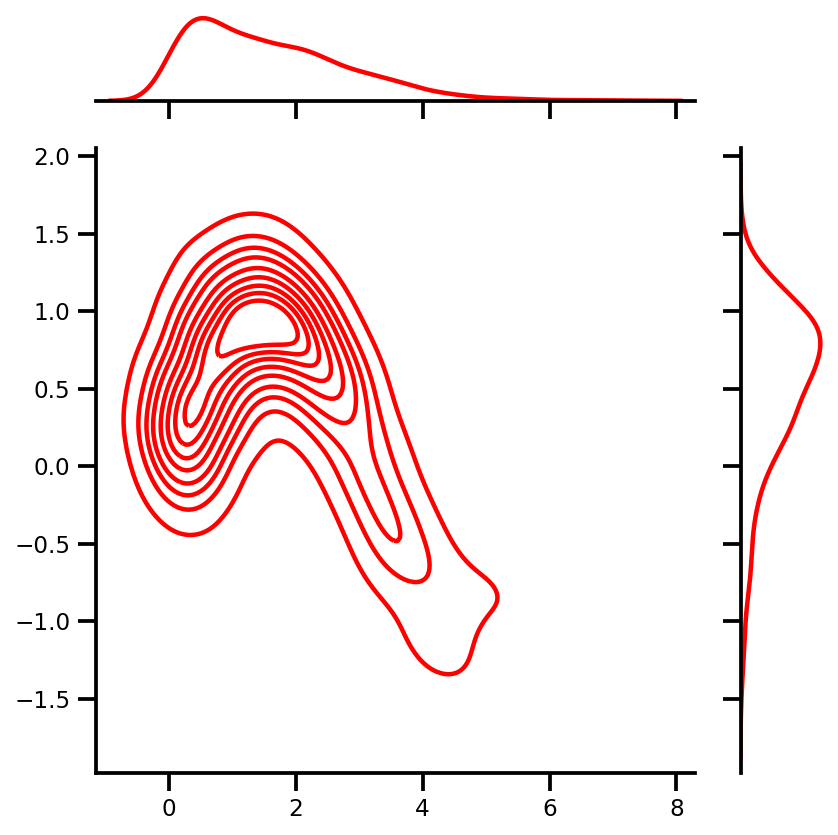

In [13]:
X_samples = get_classic(1_000)

plot_joint(X_samples)

### Marginal Histogram Uniformization

In [14]:
def get_transform_marginal(X, function: Callable):

    X = jax.vmap(function, out_axes=(0, 1))(X.T)

    return np.vstack(X).T

In [15]:
%%time

hist_transform_f = jax.partial(histogram_transform, nbins=100)
hist_transform_f_vectorized = jax.jit(jax.vmap(hist_transform_f))

def f_2d(carry, inputs):

    # marginal gaussianization
    carry = hist_transform_f_vectorized(carry.T).T    
    return carry, 0

# f = histogram_transform
init = X_samples
xs = None


CPU times: user 267 µs, sys: 0 ns, total: 267 µs
Wall time: 276 µs


#### Scan Function

In [16]:
%%time
length = 1

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 2.75 s, sys: 21 ms, total: 2.77 s
Wall time: 2.77 s


<Figure size 432x288 with 0 Axes>

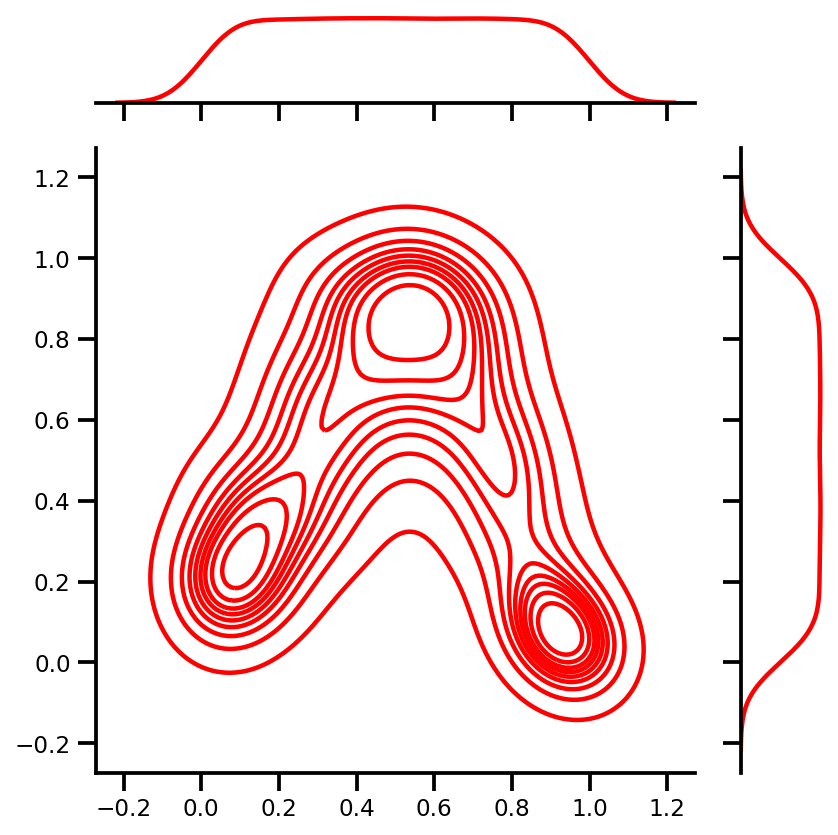

In [17]:
plot_joint(state)

### Marginal Histogram Gaussinization

In [18]:
def invgausscdf_forward_transform(X):

    return jax.scipy.stats.norm.ppf(X)

In [19]:

hist_transform_f = jax.partial(histogram_transform, nbins=100)
hist_transform_f_vectorized = jax.jit(jax.vmap(hist_transform_f))

def f_2d(carry, inputs):

    # marginal gaussianization
    carry = hist_transform_f_vectorized(carry.T).T 

    # inverse CDF transformation
    carry = invgausscdf_forward_transform(carry)
    return carry, 0

# f = histogram_transform
init = X_samples
xs = None


#### Scan Function

In [20]:
%%time
length = 1

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 2.89 s, sys: 9.87 ms, total: 2.9 s
Wall time: 2.91 s


<Figure size 432x288 with 0 Axes>

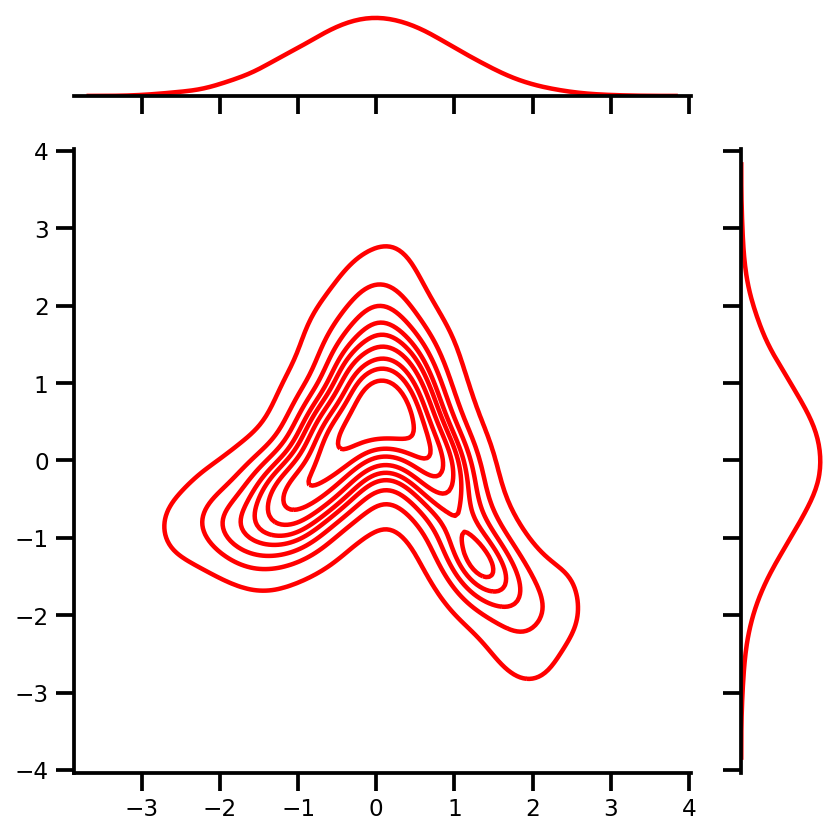

In [21]:
plot_joint(state)

### Rotation

In [22]:
def get_pca_params(X):

    R = compute_projection(X)

    return np.dot(X, R)


def compute_projection(X: np.ndarray) -> np.ndarray:
    """Compute PCA projection matrix
    Using SVD, this computes the PCA components for
    a dataset X and computes the projection matrix
    needed to do the PCA decomposition.
    Parameters
    ----------
    X : np.ndarray, (n_samples, n_features)
        the data to calculate to PCA projection matrix
    
    Returns
    -------
    VT : np.ndarray, (n_features, n_features)
        the projection matrix (V.T) for the PCA decomposition
    Notes
    -----
    Can find the original implementation here:
    https://bit.ly/2EBDV9o
    """

    # center the data
    X = X - np.mean(X, axis=0)

    # Compute SVD
    _, _, VT = np.linalg.svd(X, full_matrices=False, compute_uv=True)

    return X @ VT.T

In [23]:
%%time

hist_transform_f = jax.partial(histogram_transform, nbins=100)
hist_transform_f_vectorized = jax.jit(jax.vmap(hist_transform_f))

def f_2d(carry, inputs):

    # marginal gaussianization
    carry = hist_transform_f_vectorized(carry.T).T   

    # inverse CDF transformation
    carry = invgausscdf_forward_transform(carry)

    # rotation
    carry = compute_projection(carry)

    return carry, 0

# f = histogram_transform
init = X_samples
xs = None

CPU times: user 187 µs, sys: 0 ns, total: 187 µs
Wall time: 194 µs


#### Scan Function

In [24]:
%%time
length = 10

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 3.03 s, sys: 19.5 ms, total: 3.05 s
Wall time: 3.05 s


<Figure size 432x288 with 0 Axes>

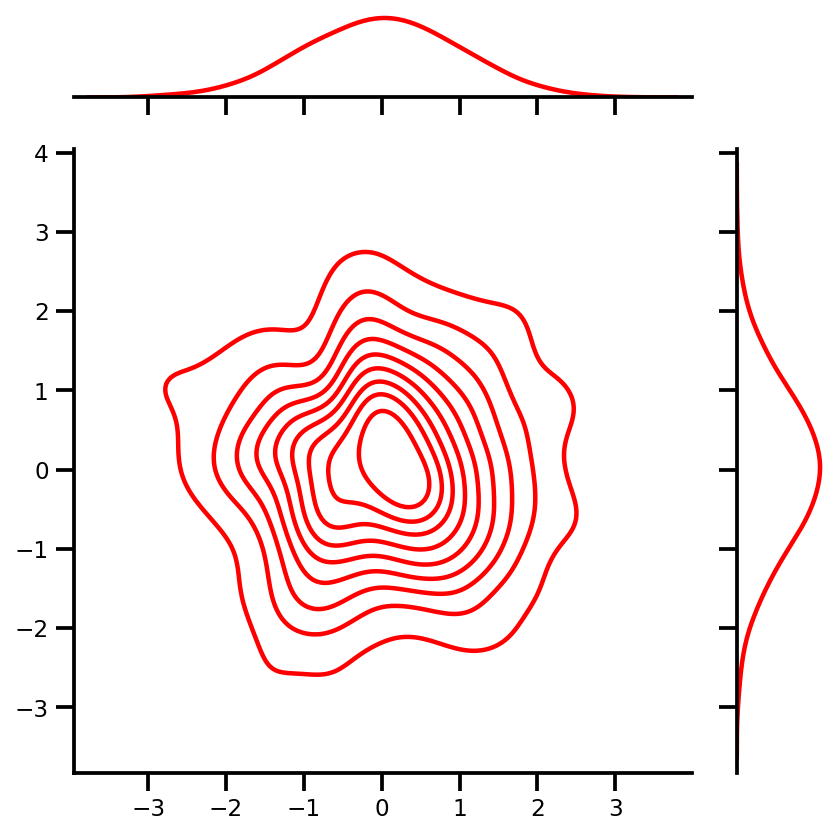

In [25]:
plot_joint(onp.asarray(state))

### Total Correlation Stopping Criteria

In [26]:
from typing import Callable 

def marginal_histogram_entropy_f(data, base: int=2, nbins: int=10):
    return jax.vmap(jax.partial(histogram_entropy, base=base, nbins=nbins))

def histogram_entropy(data, base=2, nbins: int=10):
    """Calculates the histogram entropy of 1D data.
    This function uses the histogram and then calculates
    the entropy. Does the miller-maddow correction
    
    Parameters
    ----------
    data : np.ndarray, (n_samples,)
        the input data for the entropy
    
    base : int, default=2
        the log base for the calculation.
    
    Returns
    -------
    S : float
        the entropy"""
    # get number of samples
    n_samples = np.shape(data)[0]

    # get histogram counts and bin edges
    counts, bin_edges = np.histogram(data, bins=nbins, density=False)

    # get bin centers and sizes
    bin_centers = np.mean(np.vstack((bin_edges[0:-1], bin_edges[1:])), axis=0)

    # get difference between the bins
    delta = bin_centers[3] - bin_centers[2]

    # normalize counts (density)
    pk = 1.0 * np.array(counts) / np.sum(counts)

    # calculate the entropy
    S = entropy(pk, base=base)

    # Miller Maddow Correction
    correction = 0.5 * (np.sum(counts > 0) - 1) / counts.sum()

    return S + correction + np.log2(delta)


def entropy(pk: np.ndarray, base: int = 2) -> np.ndarray:
    """calculate the entropy
    
    Notes
    -----
    Source of this module is the scipy entropy
    module which can be found - shorturl.at/pyABR
    """
    # calculate entropy
    vec = jax.scipy.special.entr(pk)

    # sum all values
    S = np.sum(vec)

    # change base
    S /= np.log(base)

    return S


def get_tolerance_dimensions(n_samples: int) -> int:
    xxx = np.logspace(2, 8, 7)
    yyy = np.array([0.1571, 0.0468, 0.0145, 0.0046, 0.0014, 0.0001, 0.00001])
    tol_dimensions = np.interp(n_samples, xxx, yyy)
    return tol_dimensions


def information_reduction(X: np.ndarray, Y: np.ndarray, entropy_f: Callable, tol_dims: int, p: float = 0.25) -> float:
    """calculates the information reduction between layers
    This function computes the multi-information (total correlation)
    reduction after a linear transformation.
    
    .. math::
        Y = XW \\
        II = I(X) - I(Y)
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Data before the transformation, where n_samples is the number
        of samples and n_features is the number of features.
    
    Y : np.ndarray, shape (n_samples, n_features)
        Data after the transformation, where n_samples is the number
        of samples and n_features is the number of features
        
    p : float, default=0.25
        Tolerance on the minimum multi-information difference
        
    Returns
    -------
    II : float
        The change in multi-information
        
    Information
    -----------
    Author: Valero Laparra
            Juan Emmanuel Johnson
    """
    # calculate the marginal entropy
    hx = jax.vmap(histogram_entropy)(X.T)
    hy = jax.vmap(histogram_entropy)(Y.T)

    # Information content
    delta_info = np.sum(hy) - np.sum(hx)
    tol_info = np.sqrt(np.sum((hy - hx) ** 2))

    # get tolerance
    n_samples, n_dimensions = X.shape

    cond = np.logical_or(
        tol_info < np.sqrt(n_dimensions * p * tol_dims ** 2), delta_info < 0
    )
    # print(type(cond), cond)
    # print(type(delta_info), delta_info)
    # print(type(0.0))
    return np.array(np.where(cond, 0.0, delta_info))

In [27]:
%%time

# entropy function
nbins = 100

entropy_f = jax.partial(histogram_entropy, nbins=100, base=2)


marginal_entropy = jax.vmap(entropy_f)
entropy_f_vectorized = jax.vmap(entropy_f)

# total correlation reduction
tol_dims = get_tolerance_dimensions(X_samples.shape[0])

total_corr_f = jax.partial(
    information_reduction, 
    entropy_f=entropy_f_vectorized,
    tol_dims=tol_dims,
    )


hist_transform_f = jax.partial(histogram_transform, nbins=100)
hist_transform_f_vectorized = jax.vmap(hist_transform_f)

def f_2d(carry, inputs):

    # marginal gaussianization
    carry_trans = hist_transform_f_vectorized(carry.T).T   

    # inverse CDF transformation
    carry_trans = invgausscdf_forward_transform(carry_trans)

    # rotation
    carry_trans = compute_projection(carry_trans)

    # information reduction
    info_red = total_corr_f(carry, carry_trans)
    # print(type(info_red))

    return carry_trans, info_red

# f = histogram_transform


CPU times: user 198 ms, sys: 4.89 ms, total: 203 ms
Wall time: 198 ms


In [28]:
%%time
init = X_samples
xs = None

X_trans, loss = f_2d(X_samples, xs)

CPU times: user 3.89 s, sys: 67.2 ms, total: 3.95 s
Wall time: 3.89 s


In [29]:
type(X_trans), type(loss)

(jax.interpreters.xla._DeviceArray, jax.interpreters.xla._DeviceArray)

#### Scan Function

In [30]:
%%time
length = 10

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 3.88 s, sys: 28.5 ms, total: 3.91 s
Wall time: 3.91 s


<Figure size 432x288 with 0 Axes>

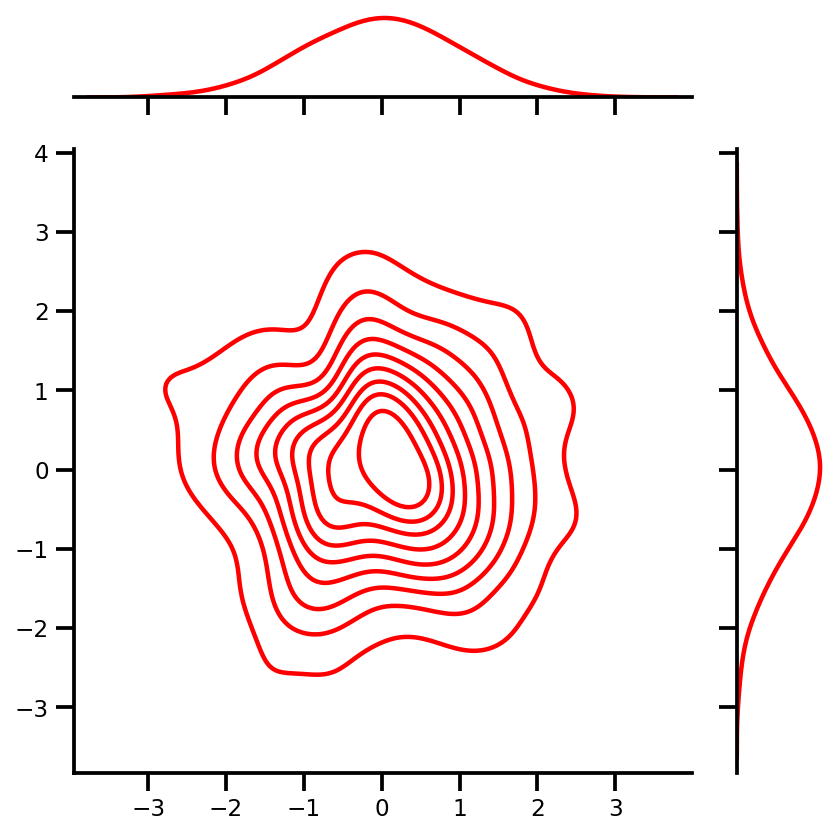

In [31]:
plot_joint(onp.asarray(state))

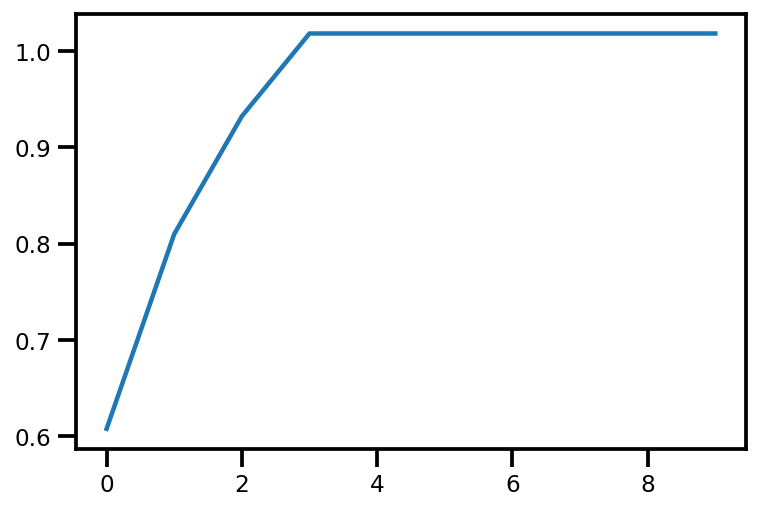

In [32]:
plt.plot(np.cumsum(results))

### 10K Points

<Figure size 432x288 with 0 Axes>

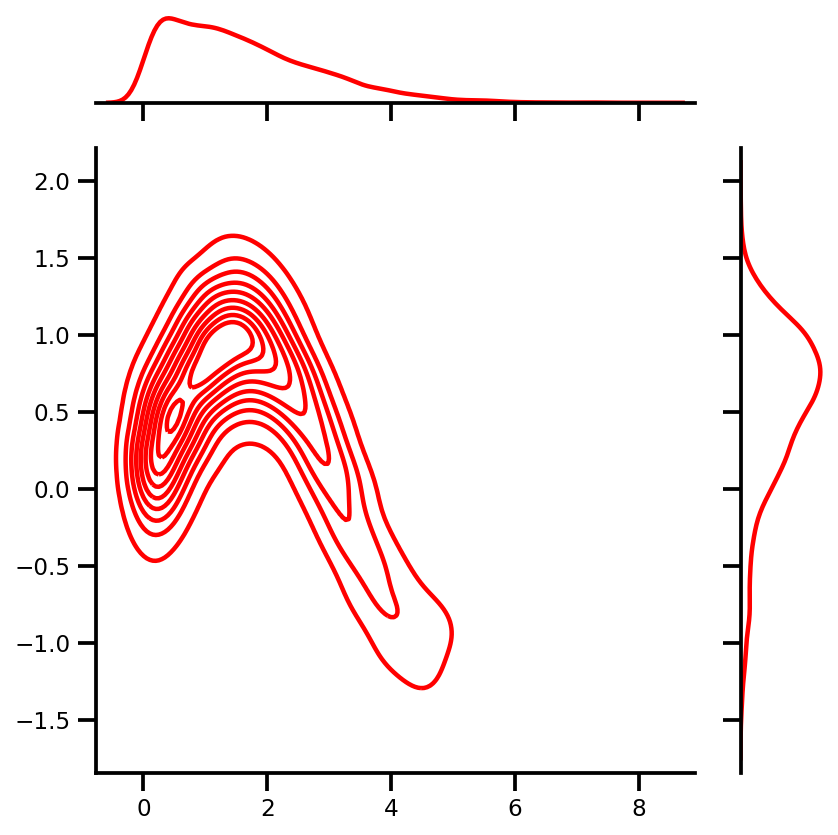

In [33]:
X_samples = get_classic(10_000)

plot_joint(X_samples)

In [34]:
%%time
# init scan function
init = np.array(X_samples)
xs = None
length = 50

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 4.49 s, sys: 43.6 ms, total: 4.53 s
Wall time: 4.53 s


<Figure size 432x288 with 0 Axes>

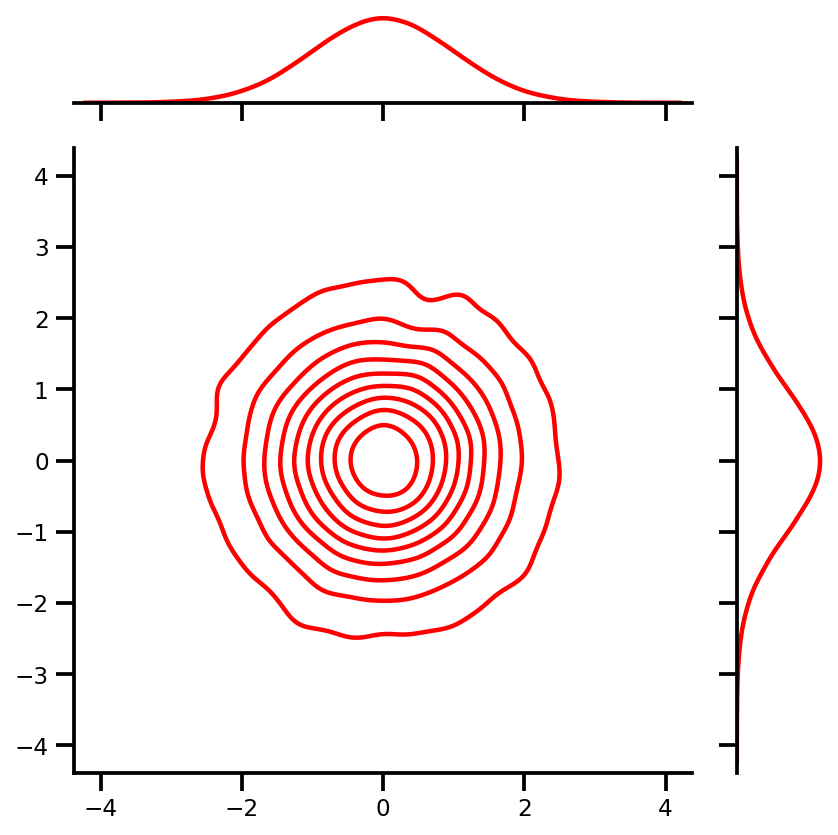

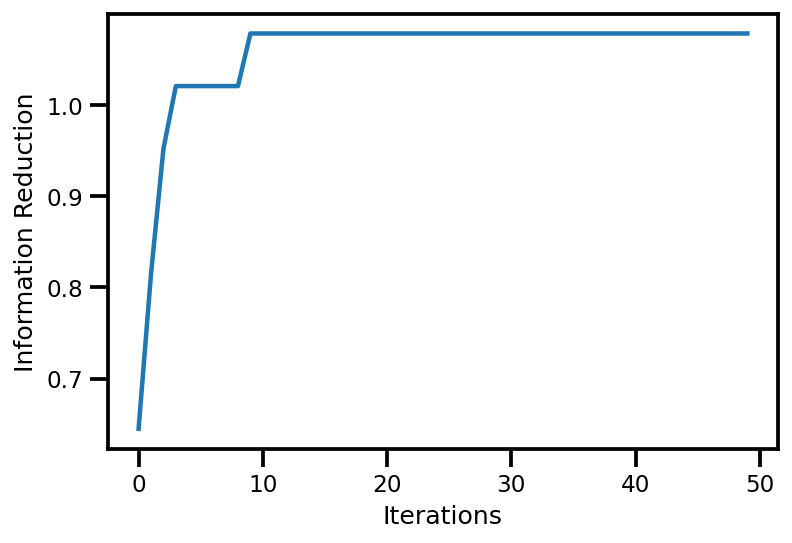

In [35]:
plot_joint(onp.asarray(state)[:10_000])

fig, ax = plt.subplots()
ax.plot(np.cumsum(results))
ax.set(
    xlabel="Iterations",
    ylabel="Information Reduction"
)
plt.show()

### 100K Points

<Figure size 432x288 with 0 Axes>

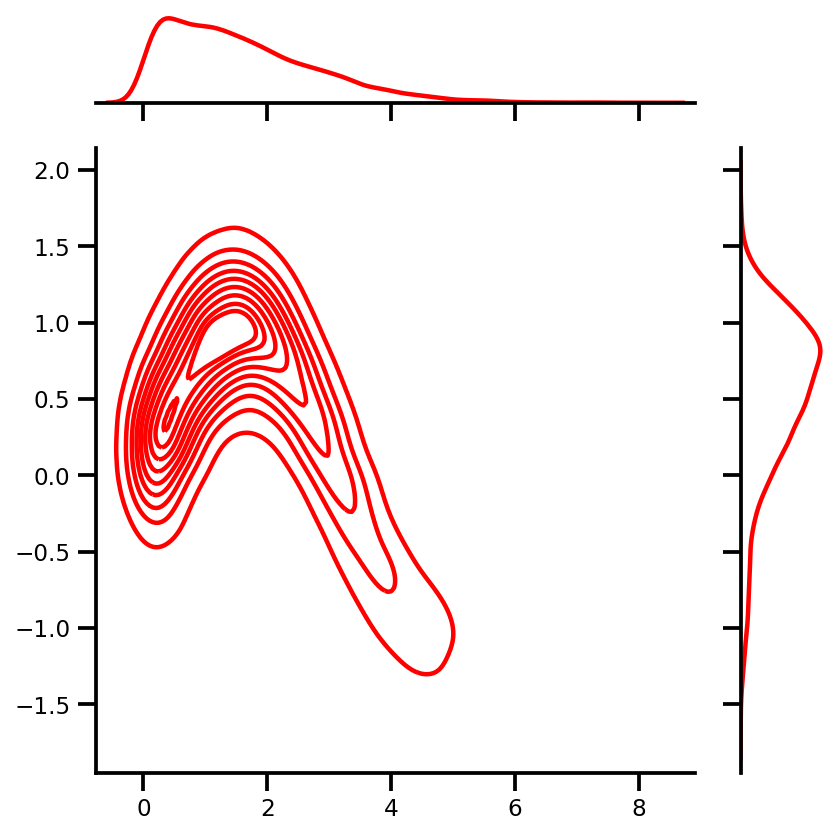

In [36]:
X_samples = get_classic(100_000)

plot_joint(X_samples[:10_000])

In [37]:
%%time
# init scan function
init = np.array(X_samples)
xs = None
length = 50

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 4.36 s, sys: 22.8 ms, total: 4.39 s
Wall time: 4.4 s


<Figure size 432x288 with 0 Axes>

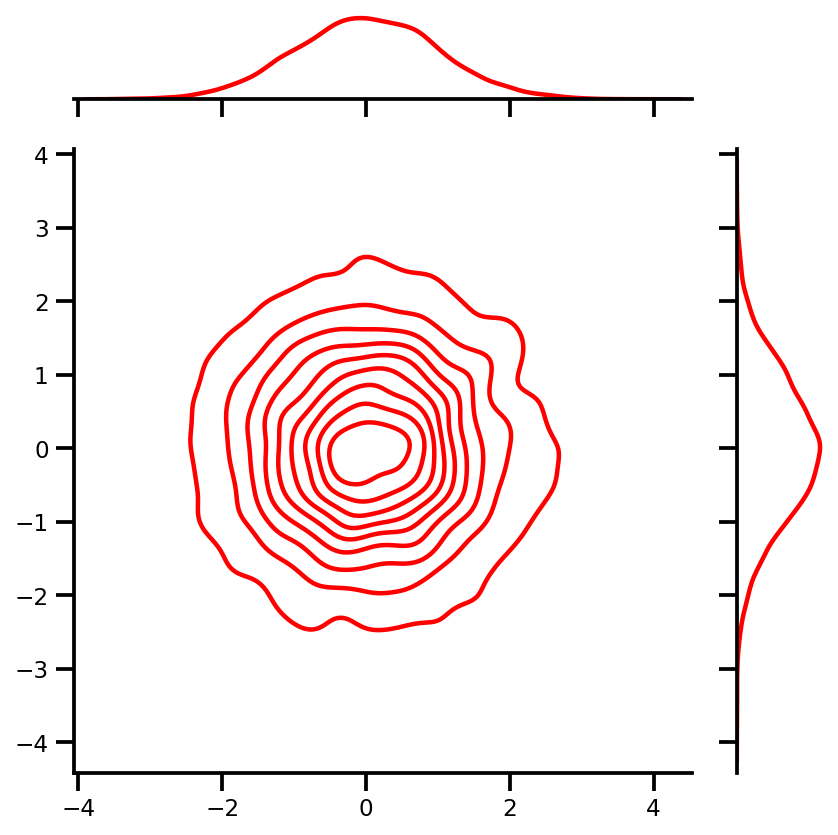

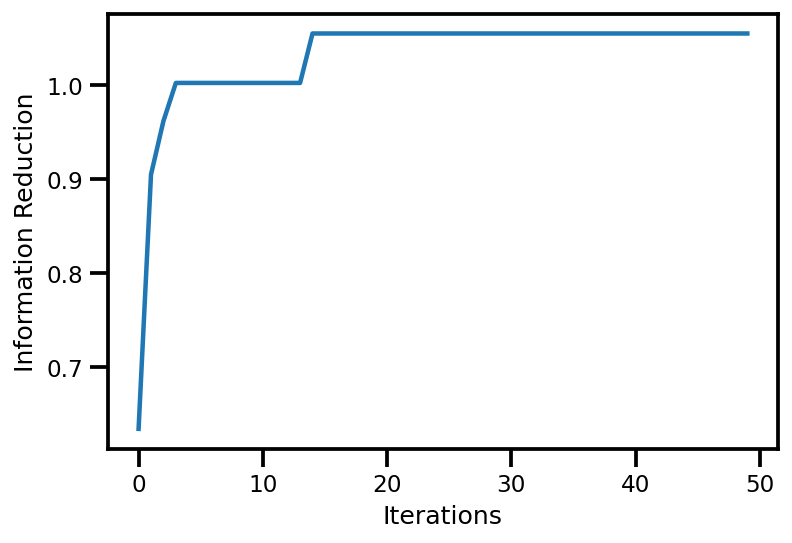

In [38]:
plot_joint(onp.asarray(state)[:10_000])

fig, ax = plt.subplots()
ax.plot(np.cumsum(results))
ax.set(
    xlabel="Iterations",
    ylabel="Information Reduction"
)
plt.show()

### 1 Million Points

<Figure size 432x288 with 0 Axes>

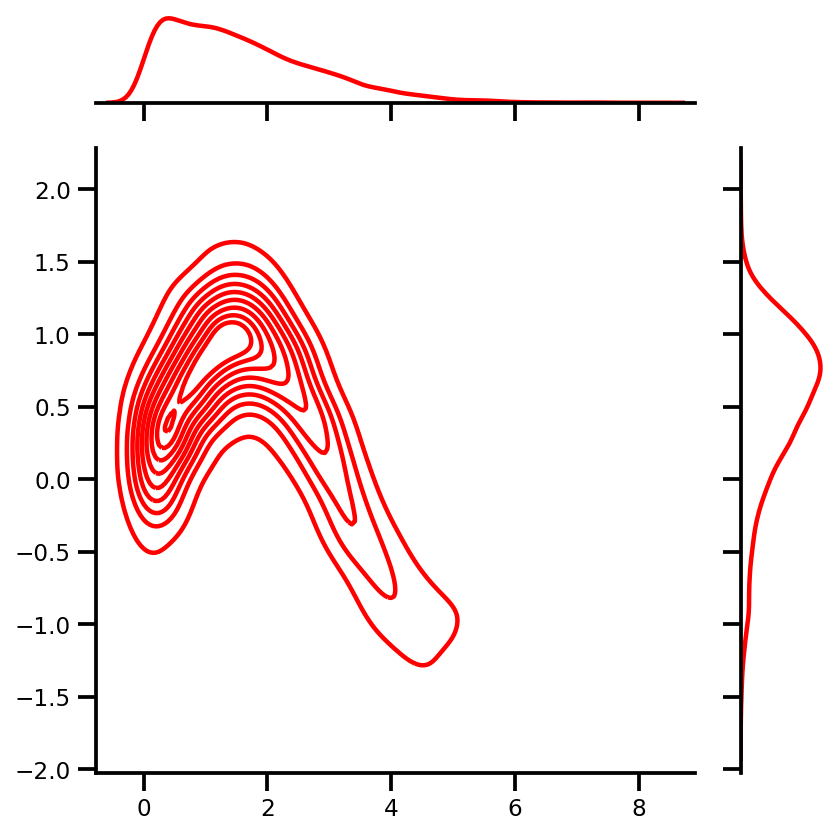

In [39]:
X_samples = get_classic(1_000_000)

plot_joint(X_samples[:10_000])

In [40]:
%%time
# init scan function
init = np.array(X_samples)
xs = None
length = 100

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 4.13 s, sys: 12.9 ms, total: 4.15 s
Wall time: 4.15 s


<Figure size 432x288 with 0 Axes>

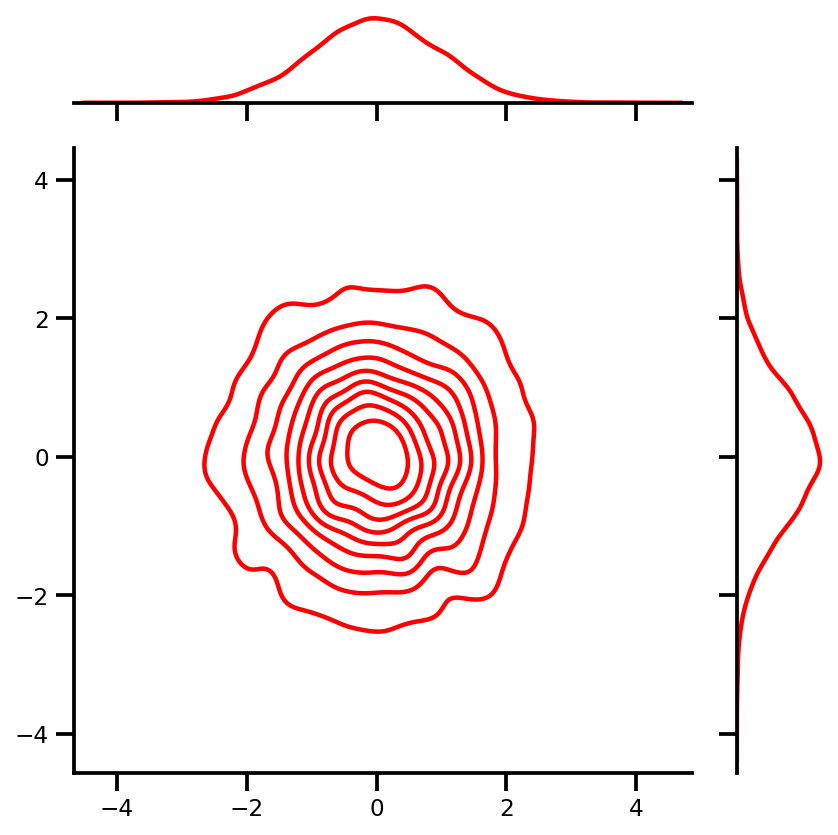

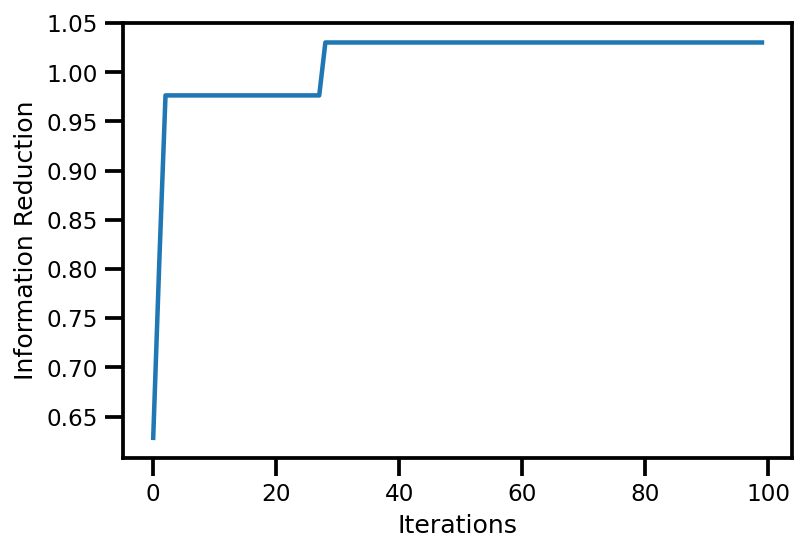

In [41]:
plot_joint(onp.asarray(state)[:10_000])

fig, ax = plt.subplots()
ax.plot(np.cumsum(results))
ax.set(
    xlabel="Iterations",
    ylabel="Information Reduction"
)
plt.show()

# Information Theory Metrics

## Total Correlation

### Dataset:  10K x 10D

In [42]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

In [43]:
%%time
# init scan function
init = np.array(data)
xs = None
length = 50

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 12.6 s, sys: 130 ms, total: 12.7 s
Wall time: 12.7 s


#### True TC

In [44]:
# covariance matrix
C = A.T @ A
vv = onp.diag(C)

tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 9.9326


#### Estimated TC

In [45]:
base = 2
tc = onp.array(np.sum(results) * np.log(base))

print(f"TC: {tc:.4f}")

TC: 9.9075


### Dataset:  100K x 100D

In [46]:
#Parameters
n_samples = 100_000
d_dimensions = 100

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 117.3796


#### Estimated TC

In [47]:
%%time
# init scan function
init = np.array(data)
xs = None
length = 50

state, results = jax.lax.scan(f=f_2d, init=init, xs=xs, length=length)

CPU times: user 5 s, sys: 110 ms, total: 5.11 s
Wall time: 5.03 s


In [48]:
%%time
results

DeviceArray([  0.   , 166.688,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
               0.   ,   0.   ], dtype=float32)

In [49]:
base = 2
info_loss = onp.asarray(results)
tc = onp.sum(info_loss) * onp.log(base)

In [50]:
print(f"TC: {tc:.4f}")

TC: 115.5395


In [51]:
print()